# Intermediate Machine Learning: Assignment 4

**Deadline**

Assignment 4 is due Thursday, November 20 by 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.


You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please convert to html and then print to pdf. (You may want to use your pdf print menu to scale the pages to be sure that cells are not truncated.) To convert to html, you can use this [converter notebook](https://colab.research.google.com/github/YData123/sds365-fa25/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb).

**Topics**

 * Graph kernels and Laplacians
 * Graph neural networks
 * Policy gradient algorithms
 * Deep Q-learning

This assignment will also help to solidify your Python skills. In particular, problem 2 uses PyTorch, whereas many of our implementations have used Tensorflow.

$\renewcommand{\reals}{{\mathbb R}}
\newcommand{\indp}{\perp\kern-4pt\perp}
\newcommand{\given}{\,|\,}$


## Problem 1: Graph kernels (20 points)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import sklearn
import random
from numpy.linalg import inv
%matplotlib inline

In [5]:
# Helper functions for third part of exercise

def rgb2gray(rgb):
    """Function to turn RGB images in greyscale images."""
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


def grid_adj(rows, cols):
    """Function that creates the adjacency matrix of
    a grid graph with predefined amount of rows and columns."""
    M = np.zeros([rows*cols, rows*cols])
    for r in np.arange(rows):
        for c in np.arange(cols):
            i = r*cols + c
            if c > 0:
                M[i-1, i] = M[i, i-1] = 1
            if r > 0:
                M[i-cols, i] = M[i, i-cols] = 1
    return M

The graph Laplacian for a weighted graph on $n$ nodes is defined as

$$ L = D - W$$

where $W$ is an $n\times n$ symmetric matrix of positive edge weights,
with $W_{ij} = 0$ if $(i,j)$ is not an edge in the graph,
and $D$ is the diagonal matrix with $D_{ii} = \sum_{j=1}^n W_{ij}$.
This generalizes the definition of the Laplacian
used in class, where all of the edge weights are one.


1. Show that $L$ is a Mercer kernel, by showing that $L$ is
  symmetric and positive-semidefinite.
<br>

2. In graph neural networks we define polynomial filters of the form

  $$ P = a_0 I + a_1 L + a_2 L^2 + \cdots a_d L^d$$
  
  where $L$ is the Laplacian and $a_0,\ldots, a_d$ are parameters,
  corresponding to the filter parameters in standard convolutional
  neural networks.

  If each $a_i \geq 0$ is non-negative, show that $P$ is also
  a Mercer kernel.
<br>



### **1**

#### **(a) Symmetry**
- $W$ is the weighted adjacency matrix of an undirected graph → $W = W^\top$.
- $D$ is diagonal → $D = D^\top$.
- Therefore  
  $$
  L^\top = (D - W)^\top = D - W = L.
  $$  
  So $L$ is symmetric.

#### **(b) Positive semidefinite**
For any vector $x\in\mathbb{R}^n$:
$$
x^\top L x = x^\top (D - W)x
= \frac{1}{2}\sum_{i,j} W_{ij}(x_i - x_j)^2.
$$
Because $W_{ij}\ge 0$ and $(x_i - x_j)^2 \ge 0$, each term is non-negative, hence
$$
x^\top L x \ge 0.
$$

Conclusion: $L$ is symmetric and positive semidefinite $L$ is a Mercer kernel.

---

### **2**

#### **(a) Symmetry**
$L$ is symmetric, so each power $L^k$ is also symmetric.  
A non-negative linear combination of symmetric matrices is symmetric.  
Thus $P$ is symmetric.

#### **(b) Positive semidefinite**
Using the eigen-decomposition $L = U\Lambda U^\top$ ($\lambda_i \ge 0$):
$$
L^k = U \Lambda^k U^\top,
$$
and therefore
$$
P = \sum_{k=0}^d a_k L^k
= U \left( \sum_{k=0}^d a_k \Lambda^k \right) U^\top.
$$

The diagonal matrix
$$
\sum_{k=0}^d a_k \Lambda^k
= \mathrm{diag}(p(\lambda_1),\ldots,p(\lambda_n)),
$$
where  
$$
p(\lambda) = \sum_{k=0}^d a_k \lambda^k, \qquad a_k\ge 0,\; \lambda\ge 0.
$$

Thus $p(\lambda_i)\ge 0$ for all $i$, so $P$ has non-negative eigenvalues → $P$ is PSD.

Equivalently, in quadratic form:  
$$
x^\top P x = \sum_{k=0}^d a_k x^\top L^k x \ge 0.
$$

$P$ is symmetric and PSD $P$ is a Mercer kernel.




3. This polynomial filter has many applications. A handful of these applications
   are based on the fact that, given a graph with a signal x, the value of $x^T L x$
   will be low in case the signal is smooth (i.e. smooth transitions of x between
   neighboring nodes). A large $x^T L x$ means that we have a rough graph signal (i.e.
   a lot of jumps in x between neighboring nodes).
   
   An intersting application that uses this property is the so-called image inpainting
   process, where an image is seen as grid graph. Image inpainting tries to restore
   a corrupted image by smoothing out the neighboring pixel values. In this problem
   we corrupt an image by turning off (i.e. making the pixel value equal to zero) a
   certain portion of the pixels. Your goal will be to restore the corrupted image
   and hence recreate the original image.
   
   First, let's corrupt an image by turning off a portion of the pixels. For this
   exercise, we choose to turn off 30% of the pixels. The result is shown below.
   Try to understand the code, as some variables might be interesting for your work.
   
   The image "Yale_Bulldogs.jpg" can be found in this GitHub repo: https://github.com/YData123/sds365-fa25/tree/main/assignments/assn4

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


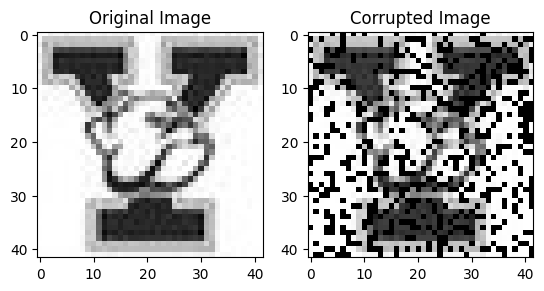

In [7]:
# Normalize the pixels of the original image
image = img.imread("/content/drive/MyDrive/Yale_Bulldogs.jpg") / 255
# Turn picture into greyscale
gray_image = rgb2gray(image)
height_img = gray_image.shape[0]
width_img = gray_image.shape[1]

# Turn off (value 0) certain pixels
fraction_off = int(0.30*height_img*width_img)
mask = np.ones(height_img*width_img, dtype=int)
# Set the first fraction of pixels off
mask[:fraction_off] = 0
# Shuffle to create randomness
np.random.shuffle(mask)
# Multiply the original image by the reshapes mask
mask = np.reshape(mask, (height_img, width_img))
corrupted_image = np.multiply(mask, gray_image)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_image, cmap=plt.get_cmap('gray'))
ax1.set_title("Original Image")
ax2.imshow(corrupted_image, cmap=plt.get_cmap('gray'))
ax2.set_title("Corrupted Image")

plt.show()

Inpainting missing pixel values can be formulated as the following
optimization problem:

$$
\underset{\textbf{x} \in \mathbb{R}^n}{\min} \left\{ \lVert \textbf{y} − \textbf{M} \textbf{x} \rVert^2_2
+ \alpha \textbf{x}^T\textbf{P}\textbf{x} \right\}
$$

where $\textbf{y} \in \mathbb{R}^n$ ($n$ being the total amount of pixels) is the corrupted graph signal
(with missing pixel values being 0) and $\alpha$ is a regularization
(smoothing) parameter that controls for smoothness of the graph. $\textbf{P}$ is the
polynomial filter based on the laplacian $\textbf{L}$. Finally, $\textbf{M}$
$\in \mathbb{R}^{n \times n}$ is a diagonal matrix that satisfies:

$$
\textbf{M}(i, i) =
    \begin{cases}
      1, \ \textrm{if $\textbf{y}$(i) is observed} \\ \\
      0, \ \textrm{if $\textbf{y}$(i) is corrupted}
    \end{cases}\,
$$

The optimization problem tries to find an $\textbf{x}$ that matches the
observed values in $\textbf{y}$, and at the same time tries to be smooth
on the graph. Start with deriving a closed form solution of this optimization
problem:

In [ ]:
# your markdown here







Define
$$
J(\mathbf{x}) = \|\mathbf{y} - \mathbf{M}\mathbf{x}\|_2^2
+ \alpha\, \mathbf{x}^\top \mathbf{P}\mathbf{x}.
$$

The first term can be written as
$$
\|\mathbf{y} - \mathbf{M}\mathbf{x}\|_2^2
= (\mathbf{y} - \mathbf{M}\mathbf{x})^\top (\mathbf{y} - \mathbf{M}\mathbf{x}).
$$

Thus
$$
J(\mathbf{x})
= (\mathbf{y} - \mathbf{M}\mathbf{x})^\top (\mathbf{y} - \mathbf{M}\mathbf{x})
+ \alpha\, \mathbf{x}^\top \mathbf{P}\mathbf{x}.
$$


We differentiate $J(\mathbf{x})$ with respect to $\mathbf{x}$.
Since $\mathbf{M}$ and $\mathbf{P}$ are symmetric (and $\mathbf{M}$ is diagonal),
we have
$$
\nabla_{\mathbf{x}} \|\mathbf{y} - \mathbf{M}\mathbf{x}\|_2^2
= -2 \mathbf{M}^\top (\mathbf{y} - \mathbf{M}\mathbf{x})
= -2 \mathbf{M} (\mathbf{y} - \mathbf{M}\mathbf{x}),
$$
and
$$
\nabla_{\mathbf{x}} \big( \alpha \mathbf{x}^\top \mathbf{P}\mathbf{x} \big)
= 2 \alpha \mathbf{P}\mathbf{x}.
$$

Therefore,
$$
\nabla_{\mathbf{x}} J(\mathbf{x})
= -2 \mathbf{M} (\mathbf{y} - \mathbf{M}\mathbf{x})
+ 2 \alpha \mathbf{P}\mathbf{x}.
$$


At the optimum $\mathbf{x}^\star$, the gradient must vanish:
$$
-2 \mathbf{M} (\mathbf{y} - \mathbf{M}\mathbf{x}^\star)
+ 2 \alpha \mathbf{P}\mathbf{x}^\star = \mathbf{0}.
$$

Divide by $2$ and rearrange:
$$
- \mathbf{M} \mathbf{y} + \mathbf{M}^2 \mathbf{x}^\star + \alpha \mathbf{P}\mathbf{x}^\star = \mathbf{0}.
$$

Because $\mathbf{M}$ is diagonal with entries $0$ or $1$, we have $\mathbf{M}^2 = \mathbf{M}$.
Thus
$$
- \mathbf{M} \mathbf{y} + \mathbf{M} \mathbf{x}^\star + \alpha \mathbf{P}\mathbf{x}^\star = \mathbf{0},
$$
or equivalently
$$
\big( \mathbf{M} + \alpha \mathbf{P} \big) \mathbf{x}^\star = \mathbf{M}\mathbf{y}.
$$



Assuming $\mathbf{M} + \alpha \mathbf{P}$ is invertible, the unique minimizer is
$$
\mathbf{x}^\star
= \big( \mathbf{M} + \alpha \mathbf{P} \big)^{-1} \mathbf{M}\mathbf{y}.
$$

This gives the closed-form solution of the inpainting problem:  
it balances data fidelity on the observed pixels (through $\mathbf{M}\mathbf{y}$)  



Next, let's restore our image. To keep things simple, let's say we already
trained the polynomial filter $\textbf{P}$ of degree 2 and we found the
following weights:

$$
\textbf{P} =  \textbf{L} + 0.05 \ \textbf{L}^2
$$

Fill in the following lines of code and show your reconstructed images next
to the corrupted image. Assume that the weights on the graph edges are equal to 1.


In [9]:
# Corrupted graph signal
y = corrupted_image.reshape(-1)

# Diagonal matrix defined as above
M = np.diag(mask.reshape(-1).astype(float))

# Adjacency matrix of the graph (by using the helper function)
A = grid_adj(height_img, width_img)

# Diagonal matrix defined as above
D = np.diag(A.sum(axis=1))

# Graph Laplacian defined as above
L = D - A

# Polynomial filter defined as above
P = L + 0.05 * (L @ L)

In [10]:
# closed form solution you derived above
x = np.linalg.solve(M + alpha * P, M @ y)

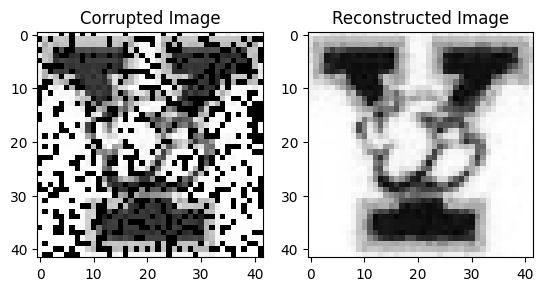

In [14]:
# Try to experiment with different alpha values
alpha = 0.1
x = np.linalg.solve(M + alpha * P, M @ y)
reconstructed_image = np.reshape(x, (height_img, width_img))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(corrupted_image, cmap=plt.get_cmap('gray'))
ax1.set_title("Corrupted Image")
ax2.imshow(reconstructed_image, cmap=plt.get_cmap('gray'))
ax2.set_title("Reconstructed Image")

plt.show()

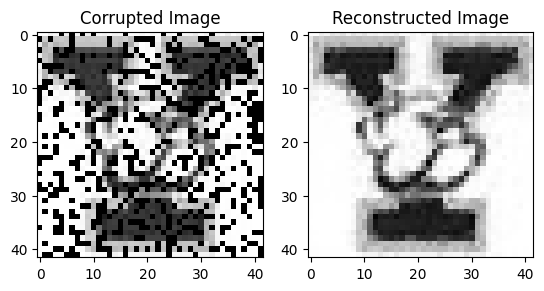

In [15]:
# Try to experiment with different alpha values
alpha = 0.01
x = np.linalg.solve(M + alpha * P, M @ y)
reconstructed_image = np.reshape(x, (height_img, width_img))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(corrupted_image, cmap=plt.get_cmap('gray'))
ax1.set_title("Corrupted Image")
ax2.imshow(reconstructed_image, cmap=plt.get_cmap('gray'))
ax2.set_title("Reconstructed Image")

plt.show()

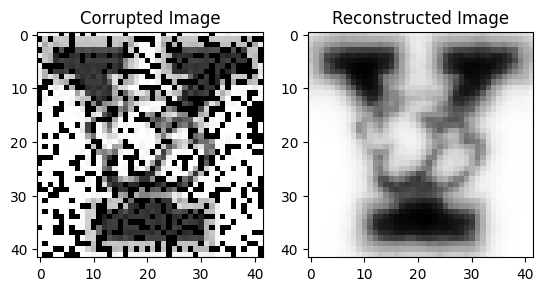

In [16]:
# Try to experiment with different alpha values
alpha = 1.0
x = np.linalg.solve(M + alpha * P, M @ y)
reconstructed_image = np.reshape(x, (height_img, width_img))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(corrupted_image, cmap=plt.get_cmap('gray'))
ax1.set_title("Corrupted Image")
ax2.imshow(reconstructed_image, cmap=plt.get_cmap('gray'))
ax2.set_title("Reconstructed Image")

plt.show()

4. Discuss the influence of the smoothing parameter $\alpha$ in
   the optimization problem above. What happens for very large
   and very low values of $\alpha$? Finally, discuss the degree
   of our polynomial function $\textbf{P}$. What happens if
   we would choose a large degree?

### Influence of the smoothing parameter α

- **Small α:**  
  The smoothness term α xᵀ P x becomes negligible.  
  The solution mainly tries to match the observed pixels:
  $$
  x \approx y.
  $$
  Missing pixels are poorly reconstructed, and the image may look noisy.

- **Large α:**  
  The smoothness term dominates the objective.  
  The solution becomes extremely smooth (nearly constant over the graph).  
  The reconstructed image becomes overly blurred and loses details.

---

### Influence of the polynomial degree of P

If we increase the degree of the polynomial filter (e.g., include L³, L⁴, …):

- Higher-degree polynomials emphasize long-range smoothing on the graph.  
  The reconstruction becomes **even smoother**, often too smooth.
- Large powers of L can cause **numerical instability** and make  
  $(M + αP)$ hard to invert.
- Higher degree also increases **computational cost**.




## Problem 2: Protein classification using GNNs (20 points)

In this problem, we focus on a **graph classification** problem using graph neural networks. Specifically, we employ GNNs to generate graph embeddings (a vector representation for each graph), which are then passed through a linear layer for classification. A common graph classification task is molecular property prediction, where molecules are represented as graphs derived from their chemical structures, and the goal is to predict their properties.

**Q1: What are some advantages of using GNN and graph representations for molecular property prediction compared to using a fully connected neural networks with tabular data? (5 points)**

### Advantages of using GNNs for molecular property prediction

1. GNNs preserve the true molecular structure (atoms as nodes, bonds as edges), which tabular data cannot.
2. Graph models are permutation-invariant and do not depend on atom ordering.
3. Message passing captures local chemical environments important for molecular properties.
4. GNNs learn structural patterns directly, while fully connected networks need heavy feature engineering.
5. Less manual feature design is required because GNNs learn representations from the graph itself.


Here, we'll use the PROTEINS datatset from [TUDataset](https://pytorch-geometric.readthedocs.io/en/2.5.1/generated/torch_geometric.datasets.TUDataset.html) and our task is to **train a model to predict if the protein is an enzyme or not**.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 53.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

# general graph information about the whole datasets
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...



Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2


Done!


As shown above, the dataset contains 1,113 proteins with binary labels, where 1 denotes an enzyme and 0 denotes a non-enzyme. We next examine and visualize the first graph in the dataset to gain a better understanding of its structure.

In [3]:
# taking a closer look at the first graph
data = dataset[0]

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of edges: 162
Average node degree: 3.86
Has isolated nodes: False
Has self-loops: False
Is undirected: True


The first graph contains 42 nodes each with 3 features and has 162 edges. A visualization of this graph is provided below.

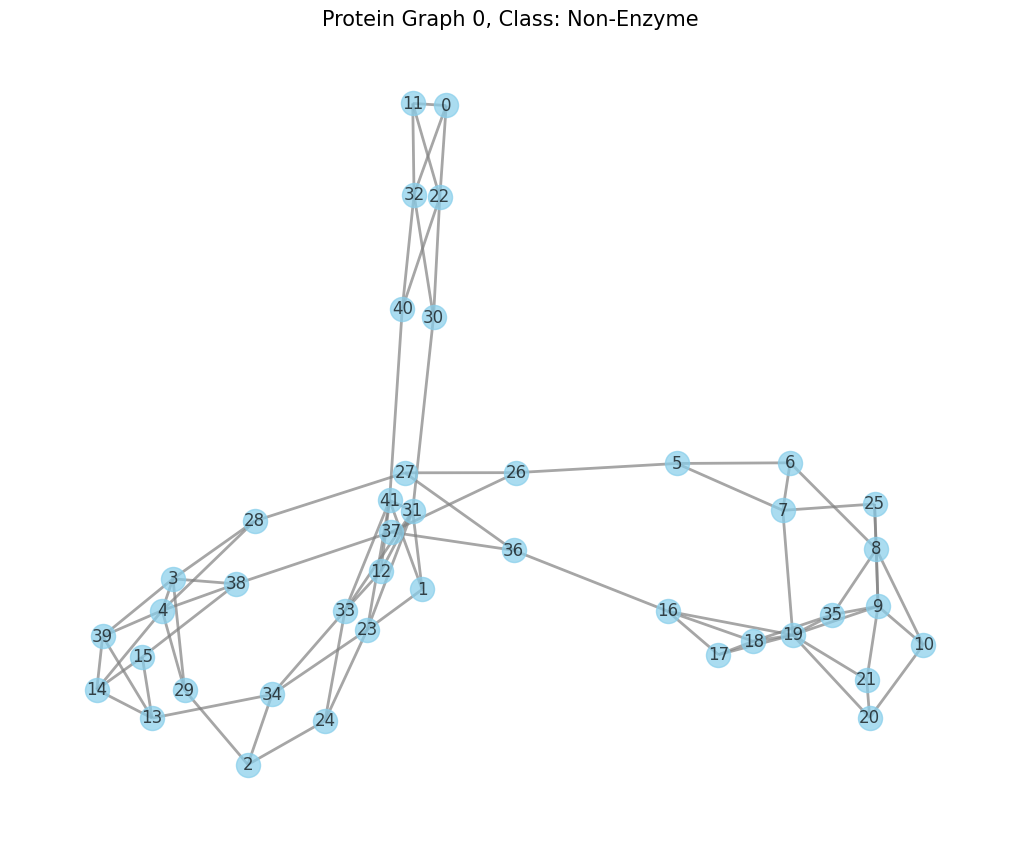

In [4]:
# Convert to NetworkX using the built-in utility
G = to_networkx(data, to_undirected=True)

# Visualization
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos,
        node_color='skyblue',
        node_size=300,
        with_labels=True,
        width=2,
        edge_color='gray',
        alpha=0.7)

plt.title(f"Protein Graph 0, Class: {"Enzyme" if data.y ==1 else "Non-Enzyme" }", fontsize=15)
plt.show()

In the following, similar to all machine learning model training pipeline, we split the dataset, batch them, and start our model building process.

In [5]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:800]
test_dataset = dataset[800:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Number of training graphs: 800
Number of test graphs: 313


A GNN model for graph classification tasks usually come with the following structure:

1. Embed each node by performing multiple rounds of message passing using layers such as Graph Convolutional Layer (more on this later)

2. Aggregate node embeddings into a unified graph embedding (through pooling methods, such as taking the mean, max, sum)

3. Train a final classifier on the graph embedding

A bit more on Graph Convolutional Layers (GCN): The mathematical operation GCN performs are described in detail [here](https://pytorch-geometric.readthedocs.io/en/2.5.0/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv).

In simple terms, during a GCN operation, each node’s new representation is obtained by aggregating (typically through a weighted average) the current representations of itself and its neighbors, followed by a linear transformation. As in fully connected neural networks, an activation function is usually applied after each GCN layer.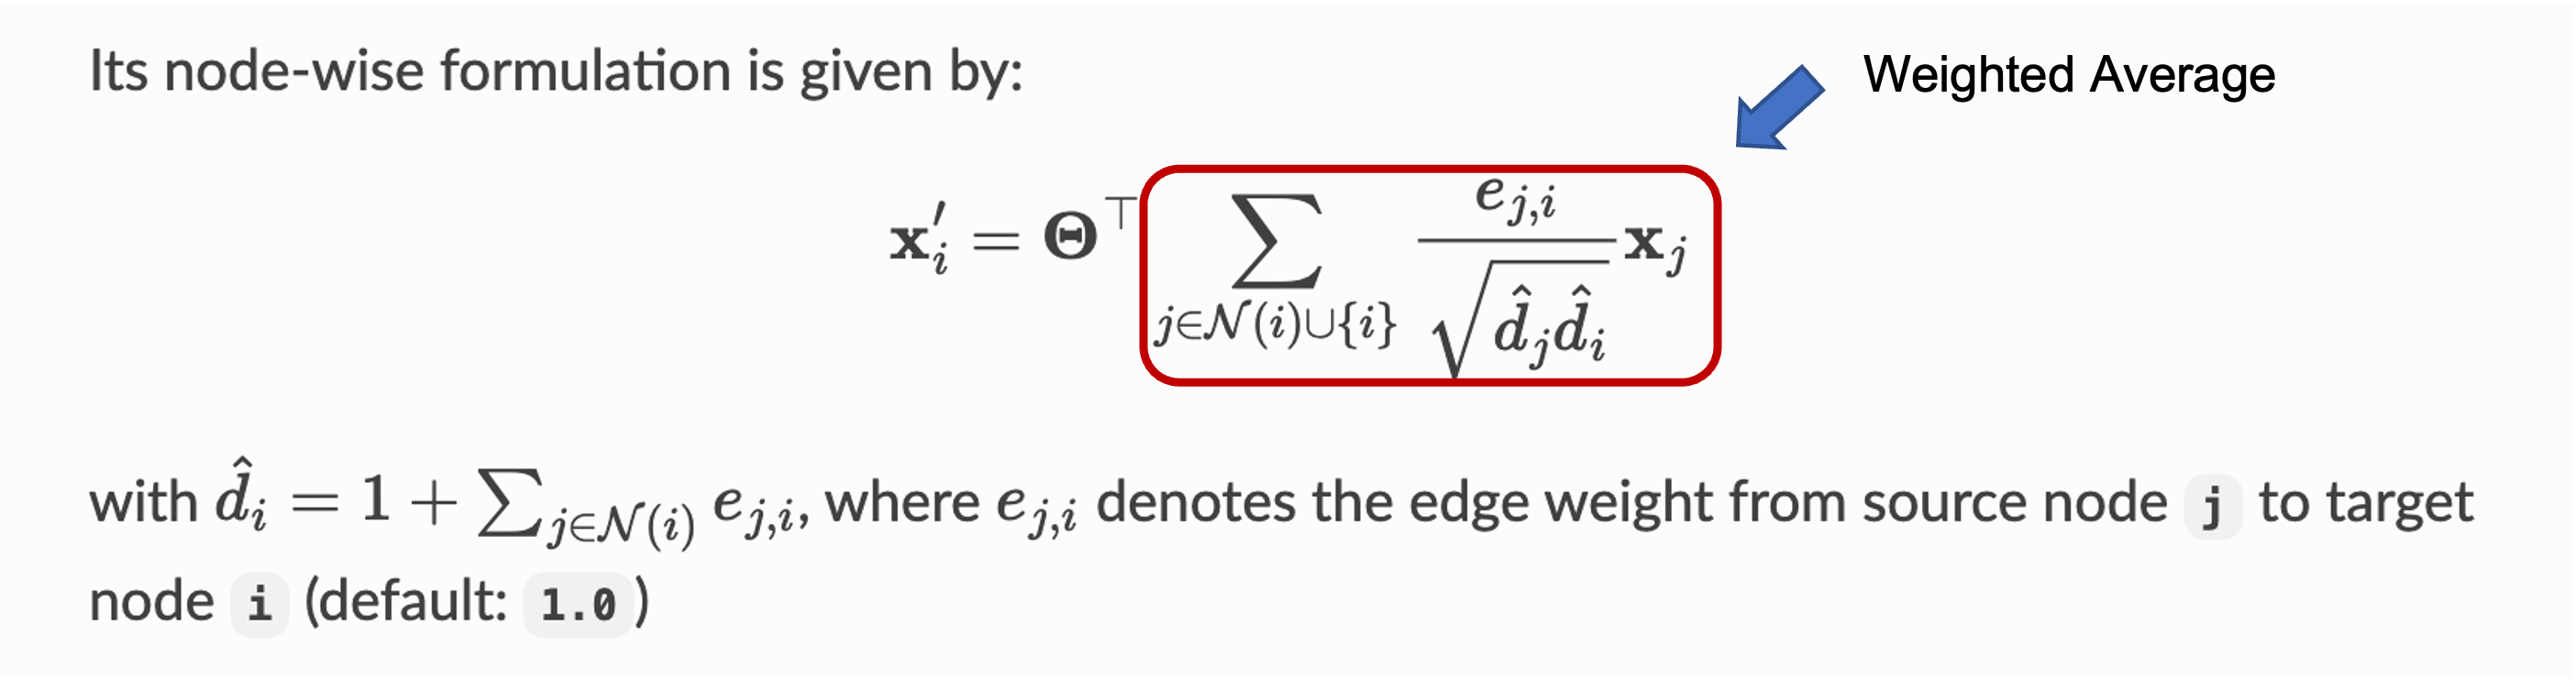

**Q2: Fill in the necessary code for GCN forward passing based on the description above and the example for the first layer (5 points)**

In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index) # first GCN layer operation
        x = x.relu()                  # activation function
        #############################
        # write your code here: how do we do GCN operation for the second and third layer
        # approximately 4 lines of code (aggregation + activation)

        # GCN layer 2 and layer 3
        x = self.conv2(x, edge_index)
        x = x.relu()

        x = self.conv3(x, edge_index)
        x = x.relu()

        #############################

        # 2. Pooling layer
        x = global_mean_pool(x, batch)  # turn node embedding into graph embedding by taking the mean of all node embeddings in the graph

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


**Q3: After generating graph embeddings, graph classification follows the standard classification pipeline. For our setup, what loss function is appropriate? Briefly explain your choice. Fill in your chosen loss function in the second line of the following code block. Feel free to check the loss function provided in torch [here](https://docs.pytorch.org/docs/stable/nn.html#loss-functions). (5 Points)**

Epoch: 001, Train Acc: 0.6438, Test Acc: 0.6070
Epoch: 002, Train Acc: 0.5988, Test Acc: 0.5879
Epoch: 003, Train Acc: 0.6488, Test Acc: 0.6198
Epoch: 004, Train Acc: 0.6725, Test Acc: 0.6454
Epoch: 005, Train Acc: 0.7113, Test Acc: 0.6869
Epoch: 006, Train Acc: 0.7163, Test Acc: 0.6965
Epoch: 007, Train Acc: 0.7000, Test Acc: 0.7061
Epoch: 008, Train Acc: 0.7250, Test Acc: 0.7125
Epoch: 009, Train Acc: 0.7225, Test Acc: 0.7093
Epoch: 010, Train Acc: 0.7288, Test Acc: 0.7125
Epoch: 011, Train Acc: 0.7087, Test Acc: 0.6901
Epoch: 012, Train Acc: 0.6800, Test Acc: 0.6518
Epoch: 013, Train Acc: 0.6963, Test Acc: 0.6997
Epoch: 014, Train Acc: 0.6900, Test Acc: 0.6390
Epoch: 015, Train Acc: 0.7050, Test Acc: 0.7061
Epoch: 016, Train Acc: 0.6975, Test Acc: 0.6901
Epoch: 017, Train Acc: 0.7125, Test Acc: 0.6773
Epoch: 018, Train Acc: 0.7288, Test Acc: 0.7188
Epoch: 019, Train Acc: 0.7288, Test Acc: 0.7125
Epoch: 020, Train Acc: 0.7087, Test Acc: 0.6741
Epoch: 021, Train Acc: 0.6887, Test Acc:

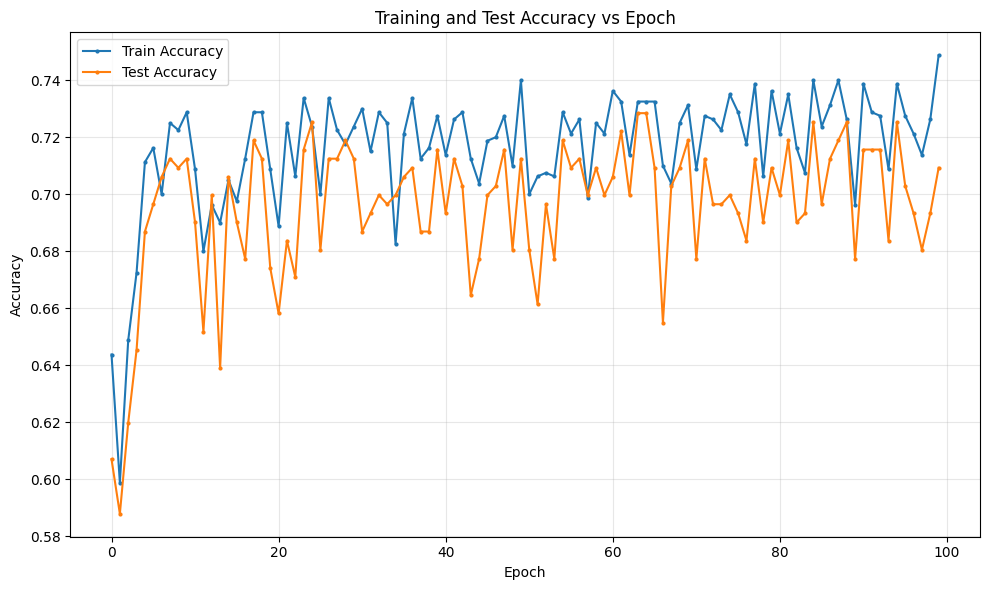

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
 ## fill in your loss function here
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

train_accs = []
test_accs = []

for epoch in range(1, 101):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_accs)), train_accs, label='Train Accuracy', marker='o', markersize=2)
plt.plot(range(len(train_accs)), test_accs, label='Test Accuracy', marker='o', markersize=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Q4:  In GNNs, adding more layers doesn't always improve performance and can sometimes dramatically decrease performance on both training and test sets. You might suspect overfitting, but overfitting wouldn't degrade training performance. This phenomenon is called oversmoothing. Based on the name and the "aggregation + activation" operation performed by each layer, what might cause this issue? (Hint: As we stack more layers, we aggregate information from increasingly distant neighbors, and...) (5 Points)**

Oversmoothing occurs because each GNN layer aggregates (averages) the features of a node with its neighbors. As we stack more layers, information is mixed across larger and larger neighborhoods. Eventually, all node representations in the graph become similar or even identical. When the embeddings lose their differences, the model cannot separate classes anymore, leading to poor performance on both training and test sets.


##  Problem 3:  Positive reinforcement  (10 points)
$\def\J{{J}}$
$\def\E{{\mathbb E}}$

As discussed in class, reinforcement learning
using policy gradient methods is based on maximizing the
expected total reward

$$ \J(\theta) = \E_\theta [R(\tau)],$$

where the expectation is over the probability distribution over sequences $\tau$ through a choice of actions using the policy. This can be rewritten as

\begin{align*}
  \nabla_\theta \J(\theta) & = \E_\theta\left[ R(\tau) \nabla_\theta \log p(\tau\given \theta) \right].
\end{align*}

Approximating this gradient involves computing $\nabla_\theta \log \pi_\theta (a \given s)$ where $\pi_\theta$ is the policy.


### 3.1 Continuous action space with Gaussian policy

Suppose that the action space is continuous
and $\pi_\theta(a\given s)$ is a normal density with mean
$\mu_\theta(s)$ and variance $\sigma^2_\theta(s)$, two outputs of
a neural network with input $s$ and parameters $\theta$.


Suppose the outputs of the neural network are given by

\begin{align*}
  \mu_\theta(s) & = \beta_1^T h(s) \\
  \sigma^2_\theta(s) &= \text{exp}(\beta_2^T h(s))
\end{align*}

where $h(s)$ is the vector of neurons in the last layer, immediately
before the outputs. Derive explicit expressions for
$\nabla_{\beta_1} \log \pi_\theta(a\given s)$ and
$\nabla_{\beta_2} \log \pi_\theta(a\given s)$.

Explain how these gradients and other gradient
terms in $\nabla_\theta \log \pi_\theta(a\given s)$ are used
to estimate the policy.



### Gradients of the Gaussian policy

For a Gaussian policy
$$
\pi_\theta(a\mid s)=\mathcal N(a;\mu,\sigma^2),
\qquad
\mu=\beta_1^\top h(s),\quad
\sigma^2=\exp(\beta_2^\top h(s)),
$$

the log-density is
$$
\log \pi_\theta(a\mid s)
= -\tfrac12\left[
\log(2\pi\sigma^2)+\frac{(a-\mu)^2}{\sigma^2}
\right].
$$

---

### Gradient w.r.t. $\beta_1$
Since
$$
\frac{\partial}{\partial \mu}\log \pi_\theta(a\mid s)
=\frac{a-\mu}{\sigma^2},
\qquad
\nabla_{\beta_1}\mu = h(s),
$$
we obtain
$$
\nabla_{\beta_1}\log \pi_\theta(a\mid s)
= \frac{a-\mu}{\sigma^2} \, h(s).
$$

---

### Gradient w.r.t. $\beta_2$
Let $v=\beta_2^\top h(s)$ so $\sigma^2=e^{v}$. Then
$$
\frac{\partial}{\partial v}\log \pi_\theta(a\mid s)
=\tfrac12\left[\frac{(a-\mu)^2}{\sigma^2}-1\right],
\qquad
\nabla_{\beta_2}v = h(s),
$$
giving
$$
\nabla_{\beta_2}\log \pi_\theta(a\mid s)
= \tfrac12\left[\frac{(a-\mu)^2}{\sigma^2}-1\right] h(s).
$$

---

### Use in policy gradient estimation
These gradients form part of
$$
\nabla_\theta J(\theta)
= \mathbb E\!\left[R(\tau)\,\nabla_\theta \log \pi_\theta(a\mid s)\right],
$$
and are combined with gradients flowing through $h(s)$ via backpropagation.  
They are averaged over sampled trajectories to update $\theta$ by gradient ascent on the expected return.


### 3.2 Discrete action space with Softmax policy

Suppose the action space is discrete with K possible actions, and the policy $\pi_\theta(a \mid s)$ is defined using a softmax function over preferences $u_\theta(s,a)$:

$$\pi_\theta(a \mid s) = \frac{\exp(u_\theta(s,a))}{\sum_a \exp(u_\theta(s,a))},$$
where $u_\theta(s,a) = \beta^T h(s,a)$, and $h(s,a)$ is a feature vector for state-action pair $(s,a)$. Derive the expression for $\nabla_\beta \log \pi_\theta(a \mid s)$.

We have
$$
\pi_\theta(a \mid s) = \frac{\exp(u_\theta(s,a))}{\sum_{b=1}^K \exp(u_\theta(s,b))},
\qquad
u_\theta(s,a) = \beta^\top h(s,a).
$$

Then
$$
\log \pi_\theta(a \mid s)
= u_\theta(s,a) - \log \sum_{b=1}^K \exp(u_\theta(s,b)).
$$

Differentiate w.r.t. $\beta$:
$$
\nabla_\beta \log \pi_\theta(a \mid s)
= \nabla_\beta u_\theta(s,a)
- \frac{1}{\sum_{b} \exp(u_\theta(s,b))}
  \sum_{b} \exp(u_\theta(s,b)) \nabla_\beta u_\theta(s,b).
$$

Since $\nabla_\beta u_\theta(s,a) = h(s,a)$, we get
$$
\nabla_\beta \log \pi_\theta(a \mid s)
= h(s,a) - \sum_{b=1}^K
\frac{\exp(u_\theta(s,b))}{\sum_{c} \exp(u_\theta(s,c))}\, h(s,b).
$$

Therefore
$$
\nabla_\beta \log \pi_\theta(a \mid s)
= h(s,a) - \sum_{b=1}^K \pi_\theta(b \mid s)\, h(s,b)
$$


## Problem 4: Deep Q-Learning for Flappy Bird (25 points)

Deep Q-learning was proposed (and patented) by DeepMind and made
a big splash when the same deep neural network architecture was shown to be able to surpass
human performance on many different Atari games, playing directly from the pixels.
In this problem, we will walk you through the implementation of deep Q-learning
to learn to play the Flappy Bird game.

<img src="https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn4/images/flappy_bird_demp.gif" width="144" height="256"/>

The implementation is based these references:
- [DeepLearningFlappyBird](https://github.com/yenchenlin/DeepLearningFlappyBird)
- [Deep Q-Learning for Atari Breakout](https://keras.io/examples/rl/deep_q_network_breakout/)

We use the `pygame` package to visualize the interaction between the algorithm
and the game environment.
However, _pygame_ is not well supported by Google Colab;
we recommend you to run the code for this problem locally.
A window will be popped up that displays
the game as it progress in real-time (as for the Cartpole demo from class).

This problem is structured as follows:

* Load necessary packages
* Test the visualization of the game, to make sure everything's working
* Process the images to reduce the dimension
* Setup the game history buffer
* Implement the core Q-learning function
* Run the learning algorithm
* Interpret the results



### Introduction

The Flappy Bird game is requires a few Python packages. Please install these _as soon as possible_, and notify us of any issues you experience so that we can help. The Python files can also be found on Canvas and in our GitHub repo at https://github.com/YData123/sds365-fa25/tree/main/assignments/assn4 .

In [3]:
from google.colab import files
uploaded = files.upload()

Saving assets.zip to assets.zip
Saving flappy_bird_utils.py to flappy_bird_utils.py
Saving wrapped_flappy_bird.py to wrapped_flappy_bird.py


In [4]:
# %pip install pygame
import numpy as np
import cv2
from collections import deque
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
import wrapped_flappy_bird as flappy_bird

# In order to write the wrapped_flappy_bird utilities, you'll need to upload the following
# three files to /content on Colab: wrapped_flappy_bird.py, flappy_bird_utils.py, assets.zip.
# Then, unzip the file assets.zip -- you can do this by opening a terminal.

pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


### The Flappy Bird environment

Interaction with the game environment is carried out through calls of the form

`(image, reward, terminal) = game.frame_step(action)`

where the meaning of these variables is as follows:

- `action`: $\binom{1}{0}$ for doing nothing, $\binom{0}{1}$ for "flapping the bird's wings"
- `image`: the image for the next step of the game, of size $(288, 512, 3)$ with three RGB channels
- `reward`: the reward received for taking the action; -1 if an obstacle is hit, 0.1 otherwise.
- `terminal`: `True` if an obstacle is hit, otherwise `False`

Now let's take a look at the game interface.
First, initiate the game:

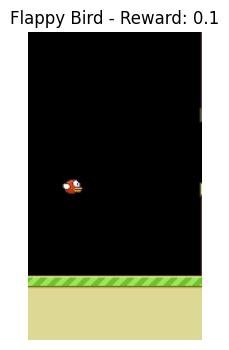

shape of image: (288, 512, 3)
reward:  0.1
terminal:  False


In [6]:
num_actions = 2

# initiate a game
game = flappy_bird.GameState()

# get the first state by doing nothing
do_nothing = np.zeros(num_actions)
do_nothing[0] = 1
image, reward, terminal = game.frame_step(do_nothing)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.imshow(image.transpose([1, 0, 2]))
plt.axis('off')
plt.title(f'Flappy Bird - Reward: {reward}')
plt.show()

print('shape of image:', image.shape)
print('reward: ', reward)
print('terminal: ', terminal)


Let's take some random actions and see what happens:

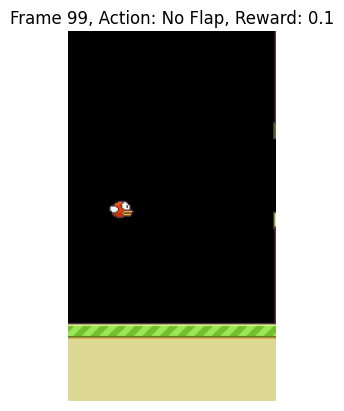

In [7]:
from IPython.display import clear_output
import time
for i in range(100):

    # choose a random action
    action = np.random.choice(num_actions)

    # create the corresponding one-hot vector
    action_vec = np.zeros(num_actions)
    action_vec[action] = 1

    # take the action and observe the reward and the next state
    image, reward, terminal = game.frame_step(action_vec)

    clear_output(wait=True)  # Clear previous frame
    time.sleep(.1)
    plt.imshow(image.transpose([1, 0, 2]))
    plt.axis('off')
    plt.title(f'Frame {i}, Action: {"Flap" if action == 0 else "No Flap"}, Reward: {reward}')
    plt.show()

Are you able to see Flappy moving across the window and crashing into things? Great! If you're
having any issues, post to EdD and we'll do our best to help you out.

Here is how we can visualize a frame of the game as an image within a cell.

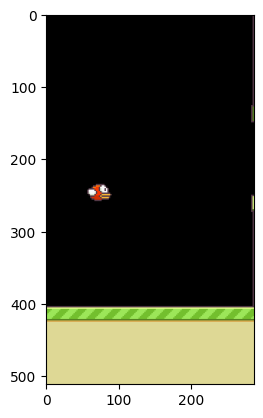

In [8]:
# show the image
import matplotlib.pyplot as plt
plt.imshow(image.transpose([1, 0, 2]))
plt.show()
plt.close()

### Preprocessing the images

Alright, next we need to prepocess the images by converting them to grayscale and resizing them to $80\times 80$ pixels. This will help
to reduce the computation, and aid learning. Besides, Flappy is
"color blind." (Fun fact: The instructor of this course is also
[color vision deficient](https://en.wikipedia.org/wiki/Color_blindness).)


Shape of the transformed image: (288, 512, 3)


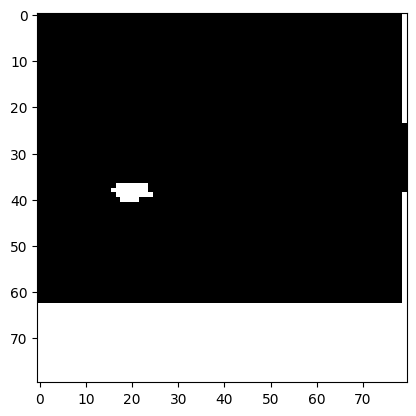

In [9]:
def resize_gray(frame):
    frame = cv2.cvtColor(cv2.resize(frame, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, frame = cv2.threshold(frame, 1, 255, cv2.THRESH_BINARY)
    return np.reshape(frame, (80, 80, 1))

image_transformed = resize_gray(image)
print('Shape of the transformed image:', image.shape)

# show the transformed image
_ = plt.imshow(image_transformed.transpose((1, 0, 2)), cmap='gray')

This shows the preprocessed image for a single frame of
the game. In our implementation of Deep Q-Learning, we encode the state by stacking four consecutive frames, resulting in
a tensor of shape (80,80,4).

Then, given the `current_state`, and a raw image `image_raw`
of size $288\times512\times3$, we convert
the raw image to a $80\times80\times 1$ grayscale image using the
code in the previous cell. The ,
we remove the first frame of `current_state` and add
the new frame, giving again a stack of images of
size (80, 80, 4).

In [10]:
def preprocess(image_raw, current_state=None):
    # resize and convert to grayscale
    image = resize_gray(image_raw)
    # stack the frames
    if current_state is None:
        state = np.concatenate((image, image, image, image), axis=2)
    else:
        state = np.concatenate((image, current_state[:, :, :3]), axis=2)
    return state

### 4.1 Explain the game state

Why is the state chosen to be a stack of four consecutive
frames rather than a single frame? Give an intuitive explanation.

[your answer here in Markdown]

A single frame only shows the bird’s position but does not contain any information about motion, such as whether the bird is moving up or falling down. This violates the Markov property. By stacking four consecutive frames, the agent can infer velocity and direction of movement from the changes between frames, which is essential for predicting the future state and choosing good actions.


###  Constructing the neural network

Now we are ready to construct the neural network for approximating the Q function. Recall that, given input $s$ which is of size $80\times80\times4$ due to the
previous preprocessing, the output of the network should be of size 2, corresponding to the values of $Q(s,a_1)$ and $Q(s, a_2)$ respectively.

Here is the summary of the model we'd like to build:

![Neural network](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn4/images/q_model.png)

### 4.2 Initialize the network

Complete the code in the next cell so that your model architecture matches that in the above picture. Here we specify the initialization of the weights by using `keras.initializers`.
Note that we haven't talked about the `strides` argument for CNNs;
you can read about stride here: [https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/). It's not important to understand this in detail, you just need to choose the number and sizes of the filters to get the shapes to match the specification.


In [13]:
from tensorflow.keras import initializers
def create_q_model():
    state = layers.Input(shape=(80, 80, 4,))

    layer1 = layers.Conv2D(filters=32, kernel_size=8, strides=4, activation="relu",
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(state)
    layer2 = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")(layer1)
    layer3 = layers.Conv2D(filters=64, kernel_size=4, strides=2, activation="relu",
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(layer2)
    layer4 = layers.Flatten()(layer3)
    q_value = layers.Dense(units=2, activation="linear",
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(layer4)

    return keras.Model(inputs=state, outputs=q_value)

Plot the model summary to make sure that the network is the same as expected.

In [14]:
model = create_q_model()
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 80, 80, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 19, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,106 (168.38 KB)

 Trainable params: 43,106 (168.38 KB)

 Non-trainable params: 0 (0.00 B)

None


### Deep Q-learning

We're now ready to implement the Q-learning algorithm.
There are some subtle details in the implementation that you need to sort out. First, recall that the update rule for Q learning is

$$Q(s,a) \leftarrow Q(s,a) + \alpha (r(s,a) + \gamma\cdot \max_{a'} Q(\text{next}(s,a), a') - Q(s,a))$$

where $\gamma$ is the discount factor and $\alpha$ can be viewed as the step size or learning rate for gradient ascent.

We'll set these as follows:

In [19]:
gamma = 0.99            # decay rate of past observations
step_size = 1e-4        # step size

### Estimation with experience replay

At the beginning of training, we spend 10,000 steps taking random
actions, as a means of observing the environment.

We build a replay memory of length 10,000 steps, and every time we update the weights of the network, we sample a batch of size 32 and perform a Q-learning update on this batch.

After we have collected 10,000 steps of new data, we discard
the old data, and replace it with the new "experiences."


In [23]:
observe = 10000            # timesteps to observe before training
replay_memory = 10000      # number of previous transitions to remember
batch_size = 32            # size of each batch


### 4.3 Justify the data collection

Why does it make sense to maintain the replay memory of a fixed size
instead of including all of the historical data?


[Your answer here in Markdown]

A fixed-size replay memory prevents the buffer from being dominated by very old experiences that no longer reflect the current policy or game dynamics. If we kept all historical data, the distribution of samples would become highly skewed toward early behavior and the agent would be repeatedly trained on outdated states.

A fixed-size buffer ensures that the training samples remain recent, diverse, and representative of the agent’s current environment, which stabilizes learning and reduces both correlation and non-stationarity in the updates.


### Exploration vs exploitation

When performing Q-learning, we face the tradeoff between exploration and
exploitation.  To encourage exploration, a simple strategy is to take a random action at each step with certain probability.

More precisely, for each time step $t$ and state $s_t$, with probability $\epsilon$, the algorithm takes a random action (wing flap or do nothing), and with probability $1-\epsilon$ the
algorithm takes a greedy action according to $a_t = \arg\max_{a} Q_\theta(s_t,a)$. Here $\theta$ refers to the parameters of our CNN.

In [18]:
# value of epsilon
epsilon = 0.05

### 4.4 Complete the Q-learning algorithm

Next you will need to complete the Q-learning algorithm by filling in the missing code in the following function.
The missing parts include

- Taking a greedy action
- Given a batch of samples $\{(s_t, a_t, r_t, s_{t+1}, \text{terminal}_t)\}_{t\in B}$, computing the corresponding $Q_\theta(s_t, a_t)$.
- Given a batch of samples $\{(s_t, a_t, r_t, s_{t+1}, \text{terminal}_t)\}_{t\in B}$, computing the corresponding updated Q-values
  
$$\hat{y}(s_t,a_t) = \begin{cases}
r_t + \gamma\, \max_{a} Q_\theta(s_{t+1}, a), & \text{if } \text{terminal}_t=0,\\
r_t, & \text{otherwise}.
\end{cases}$$

Then, the mean squared error loss for the batch is

$$\frac{1}{|B|} \sum_{t\in B} (\hat y(s_t, a_t) - Q_\theta(s_t, a_t))^2.$$



In [32]:
def dql_flappy_bird(model, optimizer, loss_function):

    # initiate a game
    game = flappy_bird.GameState()

    # store the previous state, action and transitions
    history_data = deque()

    episode_lengths = []
    episode_rewards = []

    # get the first observation by doing nothing and preprocess the image
    do_nothing = np.zeros(num_actions)
    do_nothing[0] = 1
    image, reward, terminal = game.frame_step(do_nothing)

    # preprocess to get the state
    current_state = preprocess(image_raw=image)


    episode_step = 1
    episode_reward = reward
    if terminal:
        episode_lengths.append(episode_step)
        episode_rewards.append(episode_reward)
        episode_step = 0
        episode_reward = 0.0

    # training
    t = 0

    while t < 50000:
        if epsilon > np.random.rand(1)[0]:
            # random action
            action = np.random.choice(num_actions)
        else:
            # compute the Q function
            current_state_tensor = tf.convert_to_tensor(current_state)
            current_state_tensor = tf.expand_dims(current_state_tensor, 0)
            q_value = model(current_state_tensor, training=False)

            # greedy action
            #-----MISSING-----#
            action = int(tf.argmax(q_value[0]).numpy())
            #-----------------#

        # take the action and observe the reward and the next state
        action_vec = np.zeros([num_actions])
        action_vec[action] = 1
        image_raw, reward, terminal = game.frame_step(action_vec)
        next_state = preprocess(current_state=current_state,
                                image_raw=image_raw)


        episode_step += 1
        episode_reward += reward
        if terminal:
            episode_lengths.append(episode_step)
            episode_rewards.append(episode_reward)
            episode_step = 0
            episode_reward = 0.0

        # store the observation
        history_data.append((current_state, action, reward, next_state,
                            terminal))
        if len(history_data) > replay_memory:
            history_data.popleft()  # discard old data

        # train if done observing
        if t > observe:

            # sample a batch
            batch = random.sample(history_data, batch_size)
            state_sample = np.array([d[0] for d in batch])
            action_sample = np.array([d[1] for d in batch])
            reward_sample = np.array([d[2] for d in batch])
            state_next_sample = np.array([d[3] for d in batch])
            terminal_sample = np.array([d[4] for d in batch])

            # compute the updated Q-values for the samples
            #-----MISSING-----#
            state_next_tensor = tf.convert_to_tensor(state_next_sample, dtype=tf.float32)
            q_next = model(state_next_tensor, training=False)
            max_q_next = tf.reduce_max(q_next, axis=1).numpy()
            # compute target y_hat
            done_mask = terminal_sample.astype(np.float32)
            target_for_action = reward_sample + (1.0 - done_mask) * gamma * max_q_next

            # start from current Q
            state_tensor = tf.convert_to_tensor(state_sample, dtype=tf.float32)
            q_current_full = model(state_tensor, training=False).numpy()

            for i, a in enumerate(action_sample):
              q_current_full[i, a] = target_for_action[i]


            updated_q_value = tf.convert_to_tensor(q_current_full, dtype=tf.float32)


            #-----------------#

            # train the model on the states and updated Q-values
            with tf.GradientTape() as tape:
                # compute the current Q-values for the samples
                current_q_value = model(state_tensor, training=True)

                # compute the loss
                loss = loss_function(updated_q_value, current_q_value)

            # backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        else:
            loss = 0

        # update current state and counter
        current_state = next_state
        t += 1

        # print info every 500 steps
        if t % 500 == 0:
            print(f"STEP {t} | PHASE {'observe' if t<=observe else 'train'}",
                  f"| ACTION {action} | REWARD {reward} | LOSS {loss}")
    return episode_lengths, episode_rewards

You're now ready to play the game! Just run the cell below; do not change the code.

In [37]:
def playgame():

    #! DO NOT change the random seed !
    np.random.seed(4)

    model = create_q_model()

    # specify the optimizer and loss function
    optimizer = keras.optimizers.Adam(learning_rate=step_size, clipnorm=1.0)
    loss_function = keras.losses.MeanSquaredError()

    # play the game
    episode_lengths, episode_rewards = dql_flappy_bird(
        model=model,
        optimizer=optimizer,
        loss_function=loss_function
    )
    return model, episode_lengths, episode_rewards

In [38]:
#playgame()
model, episode_lengths, episode_rewards = playgame()

STEP 500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 1000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 1500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 2000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 2500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 3000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 3500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 4000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 4500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 5000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 5500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 6000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 6500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 7000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 7500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 8000 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 0
STEP 8500 | PHASE observe | ACTION 0 | REWARD 0.1 | LOSS 

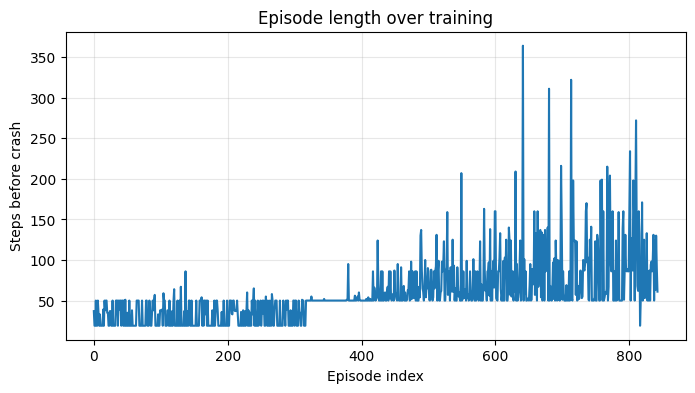

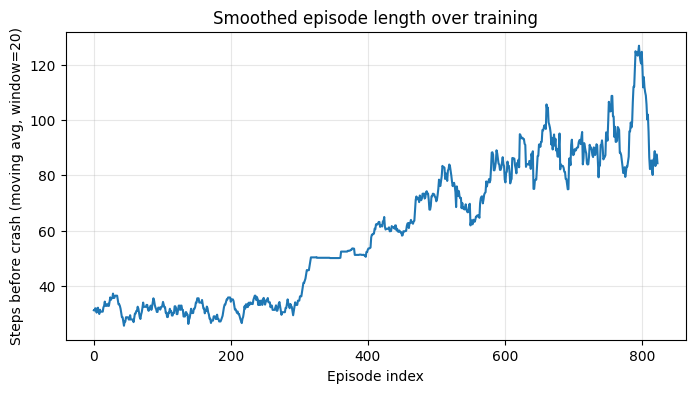

In [39]:
import matplotlib.pyplot as plt
import numpy as np
# steps
plt.figure(figsize=(8, 4))
plt.plot(episode_lengths)
plt.xlabel("Episode index")
plt.ylabel("Steps before crash")
plt.title("Episode length over training")
plt.grid(True, alpha=0.3)
plt.show()
# average 20 steps
window = 20
if len(episode_lengths) >= window:
    moving_avg = np.convolve(episode_lengths,
                             np.ones(window)/window,
                             mode='valid')
    plt.figure(figsize=(8, 4))
    plt.plot(moving_avg)
    plt.xlabel("Episode index")
    plt.ylabel(f"Steps before crash (moving avg, window={window})")
    plt.title("Smoothed episode length over training")
    plt.grid(True, alpha=0.3)
    plt.show()

### 4.5 Describe the training

Describe what you see by answering the following questions:

- In the early stage of training (within 2,000 steps in the *explore* phase),
  describe the behavior of the Flappy Bird. What do you think is the greedy policy
  given by the estimation of the Q-function in this stage?
- Describe what you see after roughly 5,000 training steps.
  Do you see any improvement?
  In particular, compare Flappy's behavior with their behavior in the early stages of
  training.
- Explain why the performance has improved, by relating to the model
  design such as the replay memory and the exploration.

[Your answer here in Markdown]

### Early stage of training (first ~2,000 steps in the explore phase)

In the early explore phase, Flappy Bird behaves almost randomly. The Q-network is untrained, and the ε-greedy policy makes frequent random actions. As a result, the bird usually crashes after 20–40 steps. The greedy policy at this stage is effectively meaningless because all Q-values are close to zero and nearly identical.

This matches the episode length plot, where early episodes stay short and noisy.

### Around 5,000–10,000 steps (early training phase)

After about 5,000 steps (as training begins), I start seeing slight improvements:
- Occasional longer survival periods.
- Episode lengths begin to show upward spikes.
- The smoothed curve rises gradually from ~30 steps to ~50–60 steps.

This indicates that the Q-network has begun to learn simple patterns such as flapping when falling too fast.

### After ~20,000+ steps (mid-stage training)

Around 20,000–30,000 steps, the improvement becomes more noticeable:
- The episode length curve contains several peaks above 100–150 steps.
- The smoothed curve rises to around 70–90 steps.
- The bird survives longer before crashing, and its behavior looks less random and more controlled.

Although performance is still unstable, the trend clearly shows that the agent is learning better policies.

### Why performance improves (replay memory + exploration)

Performance improves because of two key design components:

1. **Replay memory**  
   - The agent learns from a diverse set of past experiences instead of consecutive frames.  
   - This breaks temporal correlation and stabilizes training.  
   - Good trajectories (even rare ones) are reused many times, helping the network learn useful behaviors.

2. **ε-greedy exploration**  
   - Ensures the agent keeps exploring different actions instead of getting stuck in a poor deterministic policy.  
   - Random exploration occasionally produces longer survival episodes, which the replay buffer stores and the network later learns from.

Together, these mechanisms help the network gradually shape better Q-value estimates, leading to longer episode lengths over time, as shown in the smoothed training curve.



It takes a long time to fully train the network, so you're not required to
complete the training. Here's a [video](https://www.youtube.com/watch?v=THhUXIhjkCM) showing the performance of a well trained DQN.